## Notebook for training for stock price with rolling forecast
Forecast for last 10% of data. Forecast is done day by day.
- Sequential model
- LSTM model
- not stationary
- rolling forecast

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import scipy.stats as si
from IPython.display import Image
import datetime
import time

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from sklearn import preprocessing, metrics

%matplotlib inline

Using TensorFlow backend.


In [2]:
backup = pd.HDFStore('backup_v05.h5')
#df = backup['df']
#unscaled_seq_predictions = backup['unscaled_seq_predictions']
#unscaled_data = backup['unscaled_data']
#unscaled_lstm_predictions = backup['unscaled_lstm_predictions']
#test_data_unscaled = backup['test_data_unscaled']

### Iron Condor
The iron condor is a investment strategy using four option with the same strike date. More precise, the iron condor uses two vertical spreads, one put spread and a call spread. The put spread consists at of a short put option (P_s) with a strike price below the actual stock price and a long put option (P_l) with a strike price below the short put option P_s. The call spread consists of a short call option (C_s) above the actual stock price and a long call option (C_l) above the short call option C_s. All options have the same strike date and the spread on both legs can vary but is chosen mostly the same.
![title](Condor_strategy.png)
"A trader who buys an iron condor speculates that the spot price of the underlying instrument will be between the short strikes when the options expire where the position is the most profitable. Thus, the iron condor is an options strategy considered when the trader has a neutral outlook for the market. Buying iron condors are popular with traders who seek regular income from their trading capital. An iron condor buyer will attempt to construct the trade so that the short strikes are close enough that the position will earn a desirable net credit, but wide enough apart so that it is likely that the spot price of the underlying will remain between the short strikes for the duration of the options contract. The trader would typically play iron condors every month (if possible) thus generating monthly income with the strategy." [https://en.wikipedia.org/wiki/Iron_condor]

### Goal of the project
The goal of the project is to find a strategy to maximise the profit with an iron condor. The ideal short and long spreads should be found at any time based on data of the underlying stock and of the indices S&P500 and Nasdaq

In [3]:
def get_data(var_name,name):
    # reads in csv into DataFrame, keeps Adj Close and Volume and calculates rolling averages and 
    # rolling standard deviation of Adj Close for 4, 9 and 18 days
    # var_name: path to csv file
    # name: name of the column df
    df = pd.read_csv('data/'+var_name+'.csv',index_col='Date', parse_dates=True)
    df.rename(columns={"Adj Close": name, "Volume": name+'_volume', "Open": name+'_open'}, inplace = True)
    df.rename(columns={"High": name+'_high', "Low": name+'_low', "Close": name+'_close'}, inplace = True)
    #df.drop(['Open','High','Low','Close'],axis=1, inplace = True)
    #if name == 'google':
        #df['google_45d'] = df['google'].shift(-32) # stock price in 45 days (approx. 32 trading days)
    df[name+'_ra_04'] = df[name].rolling('4d').mean()
    df[name+'_std_04'] = df[name].rolling('4d').std()
    df[name+'_ra_09'] = df[name].rolling('9d').mean()
    df[name+'_std_09'] = df[name].rolling('9d').std()
    df[name+'_ra_18'] = df[name].rolling('18d').mean()
    df[name+'_std_18'] = df[name].rolling('18d').std()
    return df

In [4]:
def sigma_fct(df, name, days = 10):
    # For Black-Scholes I need the volatility of return of the underlying assets in the last days
    # based on https://www.wikihow.com/Calculate-Historical-Stock-Volatility
    # First the ln of daily returns is calculated for each element of names
    for name in names:
        a=pd.DataFrame()
        a['ln_daily_return'] = np.log(df[name] / df[name].shift(1))
        # next the rolling average (mean) over certain days is calculated
        a['rol_avg'] =  a['ln_daily_return'].rolling(str(days)+'d').mean()
        # next deviation from the mean is calculated
        a['dev_mean'] = a['ln_daily_return'] - a['rol_avg']
        # next variance is calculated for certain days
        a['dev_mean_sq'] = a['dev_mean']**2
        a['variance'] = a['dev_mean_sq'].rolling(str(days)+'d').sum()/(a['dev_mean_sq'].rolling(str(days)+'d').count()-1)
        # volatility is square root of variance
        # do you need annual volatility?
        df[name + '_daily_vol'] = np.sqrt(a['variance'])*np.sqrt(252) # 252 trading days in a year
        #df.drop(['ln_daily_return'])#,'rol_avg','dev_mean','dev_mean_sq','variance'])
        #return df[name + '_daily_vol']
    return df

In [5]:
def stationary_timeseries(df, damned_list = ['volume','std','short','daily']):
    # makes columns in df that are not in damned list stationary. Means it calculates the 
    # difference row by row
    columns = df.columns
    df_sta = pd.DataFrame()
    for column in columns:
        if any(elem in column for elem in damned_list):
            df_sta[column] = df[column]
        else:
            df_sta[column+'_sta'] = df[column].shift(1) - df[column]
    df_sta.dropna(inplace = True)  # to make sure we have all the data on all the days
    return df_sta

In [6]:
def get_df(var_name_list,name_list):
    # takes list paths of csv files and names and passes it on to get_data.
    # Gets df from get_data and merges them on 'Date'
    # Calls sigma_fct to get sigma of daily returns 
    # var_name_list: list of paths to csv files
    # name: list of names the columns of df
    i=0
    for var_name in var_name_list:
        if i == 0:
            df = get_data(var_name, name_list[i])
        else:
            df = pd.merge(df,get_data(var_name, name_list[i]),on='Date')
        i += 1
    df.dropna(inplace = True)  # to make sure we have all the data on all the days
    
    df = sigma_fct(df,names)
    df=df[23:] # drop first entries to get clean results

    return df

In [7]:
def get_target_data(df, name):
    # function to create the target data
    # name: name of the column the target data is created of
    df[name+'_45d'] = df[name].shift(-32) # stock price in 45 days (approx. 32 trading days)
    df.dropna(inplace = True)  # to make sure we have all the data on all the days
    # df['short_call'] shows the perfect short call. If you would have shorted a call option with a strike price 
    # exactly the same as the stock price 45 days later, you made maximum profit. Therefore this is the target 
    # value for the short call option. The minimum is 0, so we never short a call option with a strike price
    # below the stock price right now. The same for the short put option
    #df['short_call'] = [x/y-1 if x/y > 1 else 0 for x,y in df[[name+'_45d', name]].values]
    #df['short_put'] = [1-x/y if x/y < 1 else 0 for x,y in df[[name+'_45d', name]].values]
    return df

In [8]:
var_names = ['GOOG','S&P','Nasdaq2']
names = ['google','s&p','nasdaq']
df = get_df(var_names, names)
df = get_target_data(df, 'google')
df.head()

,google_open,google_high,google_low,google_close,google,google_volume,google_ra_04,google_std_04,google_ra_09,google_std_09,...,nasdaq_ra_04,nasdaq_std_04,nasdaq_ra_09,nasdaq_std_09,nasdaq_ra_18,nasdaq_std_18,google_daily_vol,s&p_daily_vol,nasdaq_daily_vol,google_45d
Date,,,,,,,,,,,,,,,,,,,,,
2008-11-21,130.764862,134.182053,123.188263,130.725006,130.725006,20565700,136.935478,8.750923,143.875715,10.798013,...,1392.540009,68.742234,1452.251430,95.188063,1541.462141,127.530682,0.716470,0.802275,0.738519,156.946732
2008-11-24,134.127258,134.470963,124.040070,128.239334,128.239334,20184700,129.482170,1.757636,137.580147,9.599201,...,1428.184998,61.992083,1420.705017,68.914436,1498.502503,101.345711,0.529842,0.864400,0.777819,155.761169
2008-11-25,133.838348,142.794769,133.160873,140.498383,140.498383,21623100,134.368858,8.668457,137.997038,8.831976,...,1468.375000,5.154837,1426.994298,65.073432,1483.279999,90.035297,0.833833,0.791313,0.710049,156.573120
2008-11-26,139.616684,147.178345,137.584305,145.499634,145.499634,12760800,138.079117,8.880829,137.425609,8.059325,...,1489.616659,36.971751,1434.144287,74.235572,1487.035382,87.259170,0.812863,0.758392,0.707779,149.923050
2008-11-28,144.747452,147.671494,143.601746,145.933014,145.933014,5150200,143.977010,3.020363,136.698456,8.236770,...,1510.799967,39.935485,1450.814982,86.016593,1480.791532,79.789023,0.871477,0.804582,0.756923,148.936752


In [9]:
backup['df'] = df

### Price of options
It is really hard to get data about historic stock options. Be it as api channel or csv download. I managed only to find sources to pay: 500 USD for every year. Because that is too expensive for this project I decided to calculate the option price with the **Black–Scholes formula**, which gives a theoretical estimate of the price of European-style options.

Based on the formula for non-divident paying options I calculate the option prices and add a small random term to create a bit of noise.

In [10]:
def black_scholes(S, K, sigma, r=0.03, T=45/365, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity in years, 45 days as default
    #r: risk-free interest rate, assumed to be constant between t and T
    #sigma: standard deviation (volatility) of RETURNS of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    #d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option == 'call':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
        
    return result

In [11]:
def option_prices(date, short_spread, long_spread, strike_days = 45):
    # calculates prices of options and calculates initial return (net premium)
    date = date_fct(date)
    P_s_strike_price, P_l_strike_price, C_s_strike_price, C_l_strike_price = strike_prices(date, short_spread, long_spread)
    sigma = get_sigma(date)
    stock_price = stock_price_fct(date)
    P_s_price = black_scholes(stock_price, P_s_strike_price, sigma, T=strike_days/365, option = 'put')
    P_l_price = black_scholes(stock_price, P_l_strike_price, sigma, T=strike_days/365, option = 'put')
    C_s_price = black_scholes(stock_price, C_s_strike_price, sigma, T=strike_days/365, option = 'call')
    C_l_price = black_scholes(stock_price, C_l_strike_price, sigma, T=strike_days/365, option = 'call')
    initial_return = P_s_price + C_s_price - P_l_price - C_l_price
    
    return P_s_price, P_l_price, C_s_price, C_l_price, initial_return

Now it is time to calculate the strike prices and option prices of all 4 options and the initial return by setting up the iron condor

### Calculate return of options
There are five different regimes for the return. R: return, P(C) put(call) option, s(l): short(long), ir: initial return, stock_price: stock price
- stock price is below long put option: R = ir + P_l_strike_price - P_s_strike_price
- stock price is between long and short put option: R = ir + stock_price - P_s_strike_price
- stock price is between short call and short put option: R = ir
- stock price is between short and long call option: R = ir - stock_price + C_s_strike price
- stock price is above long call option: R = ir - C_l_strike_price + C_s_strike_price

#### Define return function of iron condor

In [12]:
def ic_return(trading_date, short_spread, long_spread, strike_days = 45):
    P_s_strike_price, P_l_strike_price, C_s_strike_price, C_l_strike_price = strike_prices(trading_date, short_spread, long_spread)
    P_s_price, P_l_price, C_s_price, C_l_price, initial_return = option_prices(trading_date,short_spread, long_spread, strike_days)
    strike_date = date_fct(trading_date, 45)
    final_stock_price = stock_price_fct(strike_date)
    if final_stock_price < P_l_strike_price:
        final_result = initial_return + P_l_strike_price - P_s_strike_price
    elif final_stock_price >= P_l_strike_price and final_stock_price < P_s_strike_price:
        final_result = initial_return + stock_price - P_s_strike_price
    elif final_stock_price >= P_s_strike_price and final_stock_price < C_s_strike_price:
        final_result = initial_return
    elif final_stock_price >= C_s_strike_price and final_stock_price < C_l_strike_price:
        final_result = initial_return - final_stock_price + C_s_strike_price
    elif final_stock_price >= C_l_strike_price:
        final_result = initial_return - C_l_strike_price + C_s_strike_price
    maximum_result = initial_return
    return final_result

### Building the model

#### Scale data

In [13]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index = df.index)

/home/matthias/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


#### Split into train and test set

In [14]:
def get_train_test_data(data, train_test_split, batch_size):
    # data is dataframe to get train test data out of
    train_size_raw = data.shape[0]*train_test_split
    train_size = int(train_size_raw - train_size_raw % batch_size) # make train_size multiple of batch_size for "statefull = True" in LSTM
    train_data = data.iloc[0:train_size]
    test_size_raw = data.shape[0] - train_size
    test_size = int(test_size_raw - test_size_raw%batch_size) # multiple of batch_size
    test_data = data.iloc[train_size : train_size + test_size]
    x_train = train_data.drop(columns=['google_45d']) # google_45d is not for training, just for reversing stationarity
    y_train = train_data['google_45d']
    x_test = test_data.drop(columns=['google_45d'])
    y_test = test_data['google_45d']
    train_index=x_train.index
    x_columns = x_train.columns
    test_index = x_test.index
    return x_train, x_test, y_train, y_test, test_data, test_index, x_columns

In [15]:
batch_size = 10
train_test_split = 0.9
x_train, x_test, y_train, y_test, test_data, test_index, x_columns = get_train_test_data(df_scaled, train_test_split, batch_size)

### Sequential model

In [16]:
# Build the model architecture
seq_model = Sequential()
seq_model.add(Dense(128, activation='relu', input_shape=(x_train.shape[1],)))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(16, activation='relu'))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(4, activation='relu'))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(1))

# Compile the model using a loss function and an optimizer.
seq_model.compile(optimizer='adam',loss='mean_squared_error')
seq_model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               5120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_3 (Dropout)          (None, 4)                 0         
______________________

In [17]:
start_seq = time.time()
seq_history=seq_model.fit(x_train, y_train, epochs=3000, batch_size=50, verbose=1, validation_data=(x_test, y_test));
end_seq = time.time()
time_seq = end_seq - start_seq
time_seq


Train on 2370 samples, validate on 270 samples
Epoch 1/3000
2370/2370 [==============================] - 1s 229us/step - loss: 0.2206 - val_loss: 0.0661
Epoch 2/3000
2370/2370 [==============================] - 0s 67us/step - loss: 0.1033 - val_loss: 0.0683
Epoch 3/3000
2370/2370 [==============================] - 0s 94us/step - loss: 0.0941 - val_loss: 0.0791
Epoch 4/3000
2370/2370 [==============================] - 0s 65us/step - loss: 0.0849 - val_loss: 0.0730
Epoch 5/3000
2370/2370 [==============================] - 0s 105us/step - loss: 0.0771 - val_loss: 0.1048
Epoch 6/3000
2370/2370 [==============================] - 0s 103us/step - loss: 0.0801 - val_loss: 0.0626
Epoch 7/3000
2370/2370 [==============================] - 0s 113us/step - loss: 0.0704 - val_loss: 0.0856
Epoch 8/3000
2370/2370 [==============================] - 0s 81us/step - loss: 0.0711 - val_loss: 0.0709
Epoch 9/3000
2370/2370 [==============================] - 0s 90us/step - loss: 0.0686 - val_loss: 0.0744
Epo

2370/2370 [==============================] - 0s 116us/step - loss: 0.0390 - val_loss: 0.0331
Epoch 152/3000
2370/2370 [==============================] - 0s 151us/step - loss: 0.0426 - val_loss: 0.0286
Epoch 153/3000
2370/2370 [==============================] - 0s 128us/step - loss: 0.0358 - val_loss: 0.0301
Epoch 154/3000
2370/2370 [==============================] - 0s 117us/step - loss: 0.0424 - val_loss: 0.0272
Epoch 155/3000
2370/2370 [==============================] - 0s 139us/step - loss: 0.0442 - val_loss: 0.0442
Epoch 156/3000
2370/2370 [==============================] - 0s 137us/step - loss: 0.0378 - val_loss: 0.0431
Epoch 157/3000
2370/2370 [==============================] - 0s 125us/step - loss: 0.0382 - val_loss: 0.0288
Epoch 158/3000
2370/2370 [==============================] - 0s 155us/step - loss: 0.0430 - val_loss: 0.0321
Epoch 159/3000
2370/2370 [==============================] - 0s 111us/step - loss: 0.0379 - val_loss: 0.0322
Epoch 160/3000
2370/2370 [=================

2370/2370 [==============================] - 0s 28us/step - loss: 0.0368 - val_loss: 0.0457
Epoch 304/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0389 - val_loss: 0.0320
Epoch 305/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0390 - val_loss: 0.0373
Epoch 306/3000
2370/2370 [==============================] - 0s 54us/step - loss: 0.0384 - val_loss: 0.0455
Epoch 307/3000
2370/2370 [==============================] - 0s 89us/step - loss: 0.0428 - val_loss: 0.0381
Epoch 308/3000
2370/2370 [==============================] - 0s 126us/step - loss: 0.0347 - val_loss: 0.0382
Epoch 309/3000
2370/2370 [==============================] - 0s 126us/step - loss: 0.0380 - val_loss: 0.0580
Epoch 310/3000
2370/2370 [==============================] - 0s 135us/step - loss: 0.0419 - val_loss: 0.0338
Epoch 311/3000
2370/2370 [==============================] - 0s 81us/step - loss: 0.0397 - val_loss: 0.0461
Epoch 312/3000
2370/2370 [=======================

2370/2370 [==============================] - 0s 107us/step - loss: 0.0368 - val_loss: 0.0658
Epoch 456/3000
2370/2370 [==============================] - 0s 99us/step - loss: 0.0335 - val_loss: 0.0317
Epoch 457/3000
2370/2370 [==============================] - 0s 110us/step - loss: 0.0361 - val_loss: 0.0448
Epoch 458/3000
2370/2370 [==============================] - 0s 121us/step - loss: 0.0366 - val_loss: 0.0358
Epoch 459/3000
2370/2370 [==============================] - 0s 128us/step - loss: 0.0369 - val_loss: 0.0363
Epoch 460/3000
2370/2370 [==============================] - 0s 130us/step - loss: 0.0413 - val_loss: 0.0314
Epoch 461/3000
2370/2370 [==============================] - 0s 148us/step - loss: 0.0380 - val_loss: 0.0425
Epoch 462/3000
2370/2370 [==============================] - 0s 135us/step - loss: 0.0397 - val_loss: 0.0308
Epoch 463/3000
2370/2370 [==============================] - 0s 132us/step - loss: 0.0376 - val_loss: 0.0349
Epoch 464/3000
2370/2370 [==================

2370/2370 [==============================] - 0s 116us/step - loss: 0.0404 - val_loss: 0.0333
Epoch 532/3000
2370/2370 [==============================] - 0s 131us/step - loss: 0.0384 - val_loss: 0.0364
Epoch 533/3000
2370/2370 [==============================] - 0s 125us/step - loss: 0.0389 - val_loss: 0.0359
Epoch 534/3000
2370/2370 [==============================] - 0s 137us/step - loss: 0.0381 - val_loss: 0.0413
Epoch 535/3000
2370/2370 [==============================] - 0s 154us/step - loss: 0.0425 - val_loss: 0.0393
Epoch 536/3000
2370/2370 [==============================] - 0s 146us/step - loss: 0.0354 - val_loss: 0.0298
Epoch 537/3000
2370/2370 [==============================] - 0s 145us/step - loss: 0.0383 - val_loss: 0.0379
Epoch 538/3000
2370/2370 [==============================] - 0s 150us/step - loss: 0.0376 - val_loss: 0.0382
Epoch 539/3000
2370/2370 [==============================] - 0s 135us/step - loss: 0.0362 - val_loss: 0.0304
Epoch 540/3000
2370/2370 [=================

2370/2370 [==============================] - 0s 63us/step - loss: 0.0345 - val_loss: 0.0484
Epoch 684/3000
2370/2370 [==============================] - 0s 55us/step - loss: 0.0361 - val_loss: 0.0315
Epoch 685/3000
2370/2370 [==============================] - 0s 58us/step - loss: 0.0388 - val_loss: 0.0375
Epoch 686/3000
2370/2370 [==============================] - 0s 65us/step - loss: 0.0388 - val_loss: 0.0325
Epoch 687/3000
2370/2370 [==============================] - 0s 65us/step - loss: 0.0380 - val_loss: 0.0321
Epoch 688/3000
2370/2370 [==============================] - 0s 52us/step - loss: 0.0392 - val_loss: 0.0418
Epoch 689/3000
2370/2370 [==============================] - 0s 65us/step - loss: 0.0392 - val_loss: 0.0322
Epoch 690/3000
2370/2370 [==============================] - 0s 63us/step - loss: 0.0376 - val_loss: 0.0422
Epoch 691/3000
2370/2370 [==============================] - 0s 62us/step - loss: 0.0391 - val_loss: 0.0369
Epoch 692/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 65us/step - loss: 0.0366 - val_loss: 0.0367
Epoch 836/3000
2370/2370 [==============================] - 0s 61us/step - loss: 0.0368 - val_loss: 0.0337
Epoch 837/3000
2370/2370 [==============================] - 0s 60us/step - loss: 0.0389 - val_loss: 0.0474
Epoch 838/3000
2370/2370 [==============================] - 0s 63us/step - loss: 0.0401 - val_loss: 0.0438
Epoch 839/3000
2370/2370 [==============================] - 0s 63us/step - loss: 0.0385 - val_loss: 0.0418
Epoch 840/3000
2370/2370 [==============================] - 0s 60us/step - loss: 0.0392 - val_loss: 0.0344
Epoch 841/3000
2370/2370 [==============================] - 0s 63us/step - loss: 0.0383 - val_loss: 0.0618
Epoch 842/3000
2370/2370 [==============================] - 0s 59us/step - loss: 0.0379 - val_loss: 0.0377
Epoch 843/3000
2370/2370 [==============================] - 0s 57us/step - loss: 0.0398 - val_loss: 0.0407
Epoch 844/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 104us/step - loss: 0.0431 - val_loss: 0.0437
Epoch 988/3000
2370/2370 [==============================] - 0s 80us/step - loss: 0.0359 - val_loss: 0.0415
Epoch 989/3000
2370/2370 [==============================] - 0s 89us/step - loss: 0.0386 - val_loss: 0.0422
Epoch 990/3000
2370/2370 [==============================] - 0s 49us/step - loss: 0.0368 - val_loss: 0.0379
Epoch 991/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0392 - val_loss: 0.0404
Epoch 992/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0390 - val_loss: 0.0484
Epoch 993/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0359 - val_loss: 0.0340
Epoch 994/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0401 - val_loss: 0.0416
Epoch 995/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0347 - val_loss: 0.0359
Epoch 996/3000
2370/2370 [=========================

Epoch 1063/3000
2370/2370 [==============================] - 0s 135us/step - loss: 0.0368 - val_loss: 0.0472
Epoch 1064/3000
2370/2370 [==============================] - 0s 133us/step - loss: 0.0370 - val_loss: 0.0403
Epoch 1065/3000
2370/2370 [==============================] - 0s 107us/step - loss: 0.0385 - val_loss: 0.0385
Epoch 1066/3000
2370/2370 [==============================] - 0s 118us/step - loss: 0.0383 - val_loss: 0.0368
Epoch 1067/3000
2370/2370 [==============================] - 0s 119us/step - loss: 0.0418 - val_loss: 0.0483
Epoch 1068/3000
2370/2370 [==============================] - 0s 108us/step - loss: 0.0335 - val_loss: 0.0394
Epoch 1069/3000
2370/2370 [==============================] - 0s 100us/step - loss: 0.0348 - val_loss: 0.0566
Epoch 1070/3000
2370/2370 [==============================] - 0s 108us/step - loss: 0.0379 - val_loss: 0.0353
Epoch 1071/3000
2370/2370 [==============================] - 0s 115us/step - loss: 0.0408 - val_loss: 0.0357
Epoch 1072/3000
237

2370/2370 [==============================] - 0s 28us/step - loss: 0.0381 - val_loss: 0.0395
Epoch 1214/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0363 - val_loss: 0.0485
Epoch 1215/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0349 - val_loss: 0.0449
Epoch 1216/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0410 - val_loss: 0.0435
Epoch 1217/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0340 - val_loss: 0.0450
Epoch 1218/3000
2370/2370 [==============================] - 0s 35us/step - loss: 0.0376 - val_loss: 0.0559
Epoch 1219/3000
2370/2370 [==============================] - 0s 38us/step - loss: 0.0401 - val_loss: 0.0428
Epoch 1220/3000
2370/2370 [==============================] - 0s 47us/step - loss: 0.0372 - val_loss: 0.0383
Epoch 1221/3000
2370/2370 [==============================] - 0s 73us/step - loss: 0.0364 - val_loss: 0.0367
Epoch 1222/3000
2370/2370 [=================

Epoch 1289/3000
2370/2370 [==============================] - 0s 104us/step - loss: 0.0379 - val_loss: 0.0366
Epoch 1290/3000
2370/2370 [==============================] - 0s 101us/step - loss: 0.0390 - val_loss: 0.0386
Epoch 1291/3000
2370/2370 [==============================] - 0s 112us/step - loss: 0.0353 - val_loss: 0.0390
Epoch 1292/3000
2370/2370 [==============================] - 0s 108us/step - loss: 0.0386 - val_loss: 0.0532
Epoch 1293/3000
2370/2370 [==============================] - 0s 134us/step - loss: 0.0386 - val_loss: 0.0448
Epoch 1294/3000
2370/2370 [==============================] - 0s 128us/step - loss: 0.0380 - val_loss: 0.0359
Epoch 1295/3000
2370/2370 [==============================] - 0s 145us/step - loss: 0.0397 - val_loss: 0.0692
Epoch 1296/3000
2370/2370 [==============================] - 0s 141us/step - loss: 0.0342 - val_loss: 0.0488
Epoch 1297/3000
2370/2370 [==============================] - 0s 128us/step - loss: 0.0366 - val_loss: 0.0425
Epoch 1298/3000
237

Epoch 1440/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0385 - val_loss: 0.0403
Epoch 1441/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0393 - val_loss: 0.0523
Epoch 1442/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0391 - val_loss: 0.0367
Epoch 1443/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0375 - val_loss: 0.0416
Epoch 1444/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0411 - val_loss: 0.0370
Epoch 1445/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0379 - val_loss: 0.0372
Epoch 1446/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0369 - val_loss: 0.0664
Epoch 1447/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0383 - val_loss: 0.0483
Epoch 1448/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0380 - val_loss: 0.0414
Epoch 1449/3000
2370/2370 [=

Epoch 1516/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0381 - val_loss: 0.0395
Epoch 1517/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0418 - val_loss: 0.0369
Epoch 1518/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0377 - val_loss: 0.0547
Epoch 1519/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0357 - val_loss: 0.0404
Epoch 1520/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0351 - val_loss: 0.0537
Epoch 1521/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0389 - val_loss: 0.0486
Epoch 1522/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0427 - val_loss: 0.0389
Epoch 1523/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0377 - val_loss: 0.0408
Epoch 1524/3000
2370/2370 [==============================] - 0s 27us/step - loss: 0.0397 - val_loss: 0.0417
Epoch 1525/3000
2370/2370 [=

Epoch 1592/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0387 - val_loss: 0.0406
Epoch 1593/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0356 - val_loss: 0.0384
Epoch 1594/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0370 - val_loss: 0.0384
Epoch 1595/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0358 - val_loss: 0.0365
Epoch 1596/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0426 - val_loss: 0.0390
Epoch 1597/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0381 - val_loss: 0.0540
Epoch 1598/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0384 - val_loss: 0.0383
Epoch 1599/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0378 - val_loss: 0.0373
Epoch 1600/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0363 - val_loss: 0.0611
Epoch 1601/3000
2370/2370 [=

Epoch 1668/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0360 - val_loss: 0.0414
Epoch 1669/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0407 - val_loss: 0.0358
Epoch 1670/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0345 - val_loss: 0.0460
Epoch 1671/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0380 - val_loss: 0.0585
Epoch 1672/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0365 - val_loss: 0.0491
Epoch 1673/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0376 - val_loss: 0.0476
Epoch 1674/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0383 - val_loss: 0.0368
Epoch 1675/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0405 - val_loss: 0.0362
Epoch 1676/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0360 - val_loss: 0.0421
Epoch 1677/3000
2370/2370 [=

Epoch 1744/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0362 - val_loss: 0.0403
Epoch 1745/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0344 - val_loss: 0.0418
Epoch 1746/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0397 - val_loss: 0.0392
Epoch 1747/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0371 - val_loss: 0.0487
Epoch 1748/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0373 - val_loss: 0.0385
Epoch 1749/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0372 - val_loss: 0.0500
Epoch 1750/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0352 - val_loss: 0.0377
Epoch 1751/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0399 - val_loss: 0.0395
Epoch 1752/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0392 - val_loss: 0.0399
Epoch 1753/3000
2370/2370 [=

Epoch 1820/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0364 - val_loss: 0.0470
Epoch 1821/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0391 - val_loss: 0.0464
Epoch 1822/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0355 - val_loss: 0.0529
Epoch 1823/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0357 - val_loss: 0.0459
Epoch 1824/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0337 - val_loss: 0.0542
Epoch 1825/3000
2370/2370 [==============================] - 0s 40us/step - loss: 0.0385 - val_loss: 0.0614
Epoch 1826/3000
2370/2370 [==============================] - 0s 36us/step - loss: 0.0343 - val_loss: 0.0418
Epoch 1827/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0355 - val_loss: 0.0406
Epoch 1828/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0380 - val_loss: 0.0421
Epoch 1829/3000
2370/2370 [=

Epoch 1896/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0355 - val_loss: 0.0368
Epoch 1897/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0386 - val_loss: 0.0371
Epoch 1898/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0382 - val_loss: 0.0563
Epoch 1899/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0378 - val_loss: 0.0379
Epoch 1900/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0385 - val_loss: 0.0401
Epoch 1901/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0385 - val_loss: 0.0524
Epoch 1902/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0364 - val_loss: 0.0442
Epoch 1903/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0364 - val_loss: 0.0381
Epoch 1904/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0384 - val_loss: 0.0463
Epoch 1905/3000
2370/2370 [=

Epoch 1972/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0373 - val_loss: 0.0583
Epoch 1973/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0375 - val_loss: 0.0519
Epoch 1974/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0379 - val_loss: 0.0505
Epoch 1975/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0378 - val_loss: 0.0399
Epoch 1976/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0317 - val_loss: 0.0508
Epoch 1977/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0385 - val_loss: 0.0415
Epoch 1978/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0383 - val_loss: 0.0449
Epoch 1979/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0359 - val_loss: 0.0431
Epoch 1980/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0392 - val_loss: 0.0426
Epoch 1981/3000
2370/2370 [=

Epoch 2048/3000
2370/2370 [==============================] - 0s 36us/step - loss: 0.0371 - val_loss: 0.0397
Epoch 2049/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0394 - val_loss: 0.0403
Epoch 2050/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0386 - val_loss: 0.0433
Epoch 2051/3000
2370/2370 [==============================] - 0s 39us/step - loss: 0.0364 - val_loss: 0.0463
Epoch 2052/3000
2370/2370 [==============================] - 0s 87us/step - loss: 0.0373 - val_loss: 0.0461
Epoch 2053/3000
2370/2370 [==============================] - 0s 70us/step - loss: 0.0397 - val_loss: 0.0435
Epoch 2054/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0380 - val_loss: 0.0477
Epoch 2055/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0398 - val_loss: 0.0401
Epoch 2056/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0378 - val_loss: 0.0426
Epoch 2057/3000
2370/2370 [=

Epoch 2124/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0362 - val_loss: 0.0451
Epoch 2125/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0393 - val_loss: 0.0554
Epoch 2126/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0375 - val_loss: 0.0378
Epoch 2127/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0408 - val_loss: 0.0479
Epoch 2128/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0377 - val_loss: 0.0406
Epoch 2129/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0349 - val_loss: 0.0402
Epoch 2130/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0415 - val_loss: 0.0373
Epoch 2131/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0374 - val_loss: 0.0388
Epoch 2132/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0390 - val_loss: 0.0382
Epoch 2133/3000
2370/2370 [=

Epoch 2200/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0369 - val_loss: 0.0439
Epoch 2201/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0426 - val_loss: 0.0422
Epoch 2202/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0370 - val_loss: 0.0394
Epoch 2203/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0374 - val_loss: 0.0480
Epoch 2204/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0376 - val_loss: 0.0440
Epoch 2205/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0411 - val_loss: 0.0502
Epoch 2206/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0369 - val_loss: 0.0404
Epoch 2207/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0374 - val_loss: 0.0448
Epoch 2208/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0375 - val_loss: 0.0734
Epoch 2209/3000
2370/2370 [=

Epoch 2276/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0398 - val_loss: 0.0463
Epoch 2277/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0391 - val_loss: 0.0413
Epoch 2278/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0379 - val_loss: 0.0487
Epoch 2279/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0367 - val_loss: 0.0397
Epoch 2280/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0368 - val_loss: 0.0407
Epoch 2281/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0393 - val_loss: 0.0439
Epoch 2282/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0369 - val_loss: 0.0405
Epoch 2283/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0413 - val_loss: 0.0449
Epoch 2284/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0363 - val_loss: 0.0478
Epoch 2285/3000
2370/2370 [=

Epoch 2352/3000
2370/2370 [==============================] - 0s 27us/step - loss: 0.0399 - val_loss: 0.0465
Epoch 2353/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0378 - val_loss: 0.0413
Epoch 2354/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0361 - val_loss: 0.0454
Epoch 2355/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0382 - val_loss: 0.0477
Epoch 2356/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0372 - val_loss: 0.0410
Epoch 2357/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0353 - val_loss: 0.0421
Epoch 2358/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0376 - val_loss: 0.0398
Epoch 2359/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0367 - val_loss: 0.0484
Epoch 2360/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0389 - val_loss: 0.0502
Epoch 2361/3000
2370/2370 [=

Epoch 2428/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0369 - val_loss: 0.0421
Epoch 2429/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0394 - val_loss: 0.0390
Epoch 2430/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0337 - val_loss: 0.0386
Epoch 2431/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0392 - val_loss: 0.0454
Epoch 2432/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0362 - val_loss: 0.0431
Epoch 2433/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0389 - val_loss: 0.0487
Epoch 2434/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0392 - val_loss: 0.0416
Epoch 2435/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0404 - val_loss: 0.0451
Epoch 2436/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0397 - val_loss: 0.0427
Epoch 2437/3000
2370/2370 [=

Epoch 2504/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0408 - val_loss: 0.0444
Epoch 2505/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0340 - val_loss: 0.0449
Epoch 2506/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0395 - val_loss: 0.0467
Epoch 2507/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0359 - val_loss: 0.0436
Epoch 2508/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0400 - val_loss: 0.0445
Epoch 2509/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0361 - val_loss: 0.0417
Epoch 2510/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0378 - val_loss: 0.0458
Epoch 2511/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0408 - val_loss: 0.0458
Epoch 2512/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0362 - val_loss: 0.0432
Epoch 2513/3000
2370/2370 [=

Epoch 2580/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0370 - val_loss: 0.0427
Epoch 2581/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0374 - val_loss: 0.0396
Epoch 2582/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0372 - val_loss: 0.0397
Epoch 2583/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0377 - val_loss: 0.0438
Epoch 2584/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0391 - val_loss: 0.0454
Epoch 2585/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0346 - val_loss: 0.0418
Epoch 2586/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0361 - val_loss: 0.0512
Epoch 2587/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0364 - val_loss: 0.0415
Epoch 2588/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0384 - val_loss: 0.0394
Epoch 2589/3000
2370/2370 [=

Epoch 2656/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0367 - val_loss: 0.0465
Epoch 2657/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0345 - val_loss: 0.0401
Epoch 2658/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0360 - val_loss: 0.0390
Epoch 2659/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0381 - val_loss: 0.0414
Epoch 2660/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0359 - val_loss: 0.0403
Epoch 2661/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0402 - val_loss: 0.0393
Epoch 2662/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0381 - val_loss: 0.0430
Epoch 2663/3000
2370/2370 [==============================] - 0s 27us/step - loss: 0.0349 - val_loss: 0.0407
Epoch 2664/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0328 - val_loss: 0.0407
Epoch 2665/3000
2370/2370 [=

Epoch 2732/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0361 - val_loss: 0.0425
Epoch 2733/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0361 - val_loss: 0.0393
Epoch 2734/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0370 - val_loss: 0.0436
Epoch 2735/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0371 - val_loss: 0.0582
Epoch 2736/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0366 - val_loss: 0.0475
Epoch 2737/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0316 - val_loss: 0.0485
Epoch 2738/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0382 - val_loss: 0.0396
Epoch 2739/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0368 - val_loss: 0.0400
Epoch 2740/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0367 - val_loss: 0.0380
Epoch 2741/3000
2370/2370 [=

Epoch 2808/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0378 - val_loss: 0.0459
Epoch 2809/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0369 - val_loss: 0.0452
Epoch 2810/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0386 - val_loss: 0.0471
Epoch 2811/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0352 - val_loss: 0.0476
Epoch 2812/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0401 - val_loss: 0.0443
Epoch 2813/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0397 - val_loss: 0.0591
Epoch 2814/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0342 - val_loss: 0.0461
Epoch 2815/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0381 - val_loss: 0.0411
Epoch 2816/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0395 - val_loss: 0.0507
Epoch 2817/3000
2370/2370 [=

Epoch 2884/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0364 - val_loss: 0.0519
Epoch 2885/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0380 - val_loss: 0.0443
Epoch 2886/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0379 - val_loss: 0.0579
Epoch 2887/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0408 - val_loss: 0.0491
Epoch 2888/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0358 - val_loss: 0.0449
Epoch 2889/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0387 - val_loss: 0.0508
Epoch 2890/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0356 - val_loss: 0.0498
Epoch 2891/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0368 - val_loss: 0.0497
Epoch 2892/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0398 - val_loss: 0.0421
Epoch 2893/3000
2370/2370 [=

Epoch 2960/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0395 - val_loss: 0.0414
Epoch 2961/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0360 - val_loss: 0.0401
Epoch 2962/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0382 - val_loss: 0.0573
Epoch 2963/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0365 - val_loss: 0.0590
Epoch 2964/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0387 - val_loss: 0.0414
Epoch 2965/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0376 - val_loss: 0.0415
Epoch 2966/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0341 - val_loss: 0.0472
Epoch 2967/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0381 - val_loss: 0.0420
Epoch 2968/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0370 - val_loss: 0.0407
Epoch 2969/3000
2370/2370 [=

411.3968336582184

In [18]:
seq_model.evaluate(x_train, y_train)

2370/2370 [==============================] - 0s 18us/step


0.008189283659532353

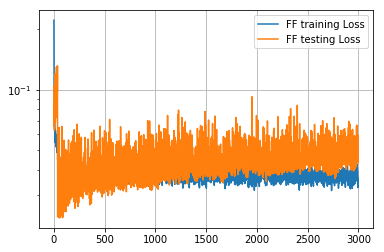

In [20]:
from matplotlib import pyplot
plt.plot(seq_history.history['loss'], label='FF training Loss')
plt.plot(seq_history.history['val_loss'], label='FF testing Loss')
plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

In [21]:
def rolling_seq_prediction(model,x_test,y_test):
    predictions = list()
    for i in x_test.index:
        # make one-step forecast
        X = x_test.loc[i].to_numpy().reshape(1,x_test.shape[1]) # reshape single line to have just 1 row
        y = y_test.loc[i]
        yhat = seq_model.predict(X).reshape(1) # reshape prediction to be just a 1D array
        # store forecast
        predictions.append(yhat[0])
    return predictions

In [22]:
yhat = rolling_seq_prediction(seq_model,x_test,y_test)
raw_seq_predictions = pd.DataFrame(yhat,columns = ['seq_prediction'], index = test_index)

In [23]:
# Invert scaling for prediction data
x_test = pd.DataFrame(x_test, columns = x_columns, index = test_index)
unscaled_seq_predictions = pd.concat([x_test, raw_seq_predictions], axis=1)
#unscaled_seq_predictions = pd.concat([unscaled_seq_predictions, test_data.google_45d], axis=1)
unscaled_seq_predictions = pd.DataFrame(scaler.inverse_transform(unscaled_seq_predictions), columns=unscaled_seq_predictions.columns, index=unscaled_seq_predictions.index)

# Invert scaling for actual data
unscaled_data = pd.concat([x_test, y_test], axis=1)
#unscaled_data = pd.concat([unscaled_data, test_data.google_45d], axis=1)
unscaled_data = pd.DataFrame(scaler.inverse_transform(unscaled_data), columns=unscaled_data.columns, index=unscaled_data.index)
#unscaled_data = unscaled_data['google_45d_sta']

In [24]:
backup['unscaled_seq_predictions'] = unscaled_seq_predictions
backup['unscaled_data'] = unscaled_data

In [25]:
unscaled_seq_predictions.head()

,google_open,google_high,google_low,google_close,google,google_volume,google_ra_04,google_std_04,google_ra_09,google_std_09,...,nasdaq_ra_04,nasdaq_std_04,nasdaq_ra_09,nasdaq_std_09,nasdaq_ra_18,nasdaq_std_18,google_daily_vol,s&p_daily_vol,nasdaq_daily_vol,seq_prediction
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-31,1220.010010,1227.588013,1205.599976,1217.260010,1217.260010,1644700.0,1218.500000,1.753611,1237.301409,24.147664,...,7650.895020,29.550020,7786.610073,109.258547,7805.587565,85.060270,0.307801,0.089192,0.152314,1060.496162
2018-08-01,1228.000000,1233.469971,1210.209961,1220.010010,1220.010010,1567200.0,1219.003337,1.515790,1239.374268,21.433011,...,7669.693359,38.687654,7767.384347,109.753646,7798.026217,85.881161,0.285090,0.083101,0.146205,1063.190143
2018-08-02,1205.900024,1229.880005,1204.790039,1226.150024,1226.150024,1531300.0,1220.790009,3.781604,1236.241420,21.550840,...,7702.942505,73.619602,7761.944336,106.402575,7798.359340,82.521365,0.271257,0.086055,0.164864,1091.418702
2018-08-03,1229.619995,1230.000000,1215.060059,1223.709961,1223.709961,1089600.0,1221.782501,3.932133,1230.528564,18.079647,...,7748.444946,69.648419,7744.768555,81.003961,7798.808594,82.581619,0.214106,0.085981,0.165144,1091.916170
2018-08-06,1225.000000,1226.088013,1215.796997,1224.770020,1224.770020,1081700.0,1224.239991,0.749575,1221.940003,3.444802,...,7835.844971,33.708070,7747.243327,90.494779,7792.345052,87.849464,0.151643,0.065983,0.139857,1082.353677


In [26]:
unscaled_data.head()

,google_open,google_high,google_low,google_close,google,google_volume,google_ra_04,google_std_04,google_ra_09,google_std_09,...,nasdaq_ra_04,nasdaq_std_04,nasdaq_ra_09,nasdaq_std_09,nasdaq_ra_18,nasdaq_std_18,google_daily_vol,s&p_daily_vol,nasdaq_daily_vol,google_45d
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-31,1220.010010,1227.588013,1205.599976,1217.260010,1217.260010,1644700.0,1218.500000,1.753611,1237.301409,24.147664,...,7650.895020,29.550020,7786.610073,109.258547,7805.587565,85.060270,0.307801,0.089192,0.152314,1156.050049
2018-08-01,1228.000000,1233.469971,1210.209961,1220.010010,1220.010010,1567200.0,1219.003337,1.515790,1239.374268,21.433011,...,7669.693359,38.687654,7767.384347,109.753646,7798.026217,85.881161,0.285090,0.083101,0.146205,1161.219971
2018-08-02,1205.900024,1229.880005,1204.790039,1226.150024,1226.150024,1531300.0,1220.790009,3.781604,1236.241420,21.550840,...,7702.942505,73.619602,7761.944336,106.402575,7798.359340,82.521365,0.271257,0.086055,0.164864,1171.089966
2018-08-03,1229.619995,1230.000000,1215.060059,1223.709961,1223.709961,1089600.0,1221.782501,3.932133,1230.528564,18.079647,...,7748.444946,69.648419,7744.768555,81.003961,7798.808594,82.581619,0.214106,0.085981,0.165144,1186.869995
2018-08-06,1225.000000,1226.088013,1215.796997,1224.770020,1224.770020,1081700.0,1224.239991,0.749575,1221.940003,3.444802,...,7835.844971,33.708070,7747.243327,90.494779,7792.345052,87.849464,0.151643,0.065983,0.139857,1166.089966


In [27]:
seq_accuracy=np.sqrt(metrics.mean_squared_error(unscaled_data.google_45d, unscaled_seq_predictions.seq_prediction))

/home/matthias/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


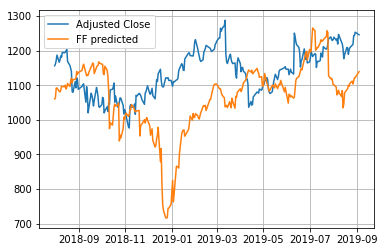

In [28]:
# Plot prediction vs actual
plt.plot(unscaled_data['google_45d'], label='Adjusted Close')
plt.plot(unscaled_seq_predictions['seq_prediction'], label='FF predicted')
plt.grid()
plt.legend()
plt.show()

### LSTM model

#### Split into train and test set
And here you have to be careful according to https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/ :

"A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input. In Keras, this is referred to as stateful, and involves setting the “stateful” argument to “True” when defining an LSTM layer. By default, an LSTM layer in Keras maintains state between data within one batch. A batch of data is a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine-grained control over when state of the LSTM layer is cleared, by calling the reset_states() function."

But in order to can use "stateful = True" the data has to be a multiple of the batch size. Therefore I have to use modulo to get the test size correctly

In [29]:
batch_size = 10
train_test_split = 0.9
x_train, x_test, y_train, y_test, test_data, test_index, x_columns = get_train_test_data(df_scaled, train_test_split, batch_size)

In [30]:
x_train=x_train.to_numpy()
y_train=y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()
# Reshape data for (Sample, Timesteps, Features)
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test_reshaped = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

In [31]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=100, input_shape = (x_train.shape[1], x_train.shape[2]), dropout = 0.2, return_sequences = True))
#lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 100, dropout = 0.2))
#lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer = 'adam', loss='mse')
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 100)            56000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 136,501
Trainable params: 136,501
Non-trainable params: 0
_________________________________________________________________


In [32]:
start_lstm = time.time()
lstm_model.reset_states()
history=lstm_model.fit(x_train, y_train, epochs=100, batch_size=batch_size, verbose=1, validation_data=(x_test_reshaped, y_test));
end_lstm = time.time()
time_lstm = end_lstm - start_lstm
time_lstm

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2370 samples, validate on 270 samples
Epoch 1/100
2370/2370 [==============================] - 4s 2ms/step - loss: 0.0244 - val_loss: 0.0175
Epoch 2/100
2370/2370 [==============================] - 3s 1ms/step - loss: 0.0092 - val_loss: 0.0162
Epoch 3/100
2370/2370 [==============================] - 3s 1ms/step - loss: 0.0084 - val_loss: 0.0161
Epoch 4/100
2370/2370 [==============================] - 3s 1ms/step - loss: 0.0085 - val_loss: 0.0193
Epoch 5/100
2370/2370 [==============================] - 3s 1ms/step - loss: 0.0081 - val_loss: 0.0161
Epoch 6/100
2370/2370 [==============================] - 3s 1ms/step - loss: 0.0077 - val_loss: 0.0179
Epoch 7/100
2370/2370 [==============================] - 2s 991us/step - loss: 0.0075 - val_loss: 0.0197
Epoch 8/100
2370/2370 [==============================] - 3s 1ms/step - loss: 0.0072 - val_loss: 0.0155
Epoch 9/100
2370/2370 [==========

2370/2370 [==============================] - 1s 425us/step - loss: 0.0040 - val_loss: 0.0182
Epoch 76/100
2370/2370 [==============================] - 1s 424us/step - loss: 0.0041 - val_loss: 0.0178
Epoch 77/100
2370/2370 [==============================] - 1s 425us/step - loss: 0.0043 - val_loss: 0.0183
Epoch 78/100
2370/2370 [==============================] - 1s 422us/step - loss: 0.0041 - val_loss: 0.0185
Epoch 79/100
2370/2370 [==============================] - 1s 422us/step - loss: 0.0040 - val_loss: 0.0195
Epoch 80/100
2370/2370 [==============================] - 1s 424us/step - loss: 0.0040 - val_loss: 0.0187
Epoch 81/100
2370/2370 [==============================] - 1s 423us/step - loss: 0.0039 - val_loss: 0.0237
Epoch 82/100
2370/2370 [==============================] - 1s 424us/step - loss: 0.0040 - val_loss: 0.0229
Epoch 83/100
2370/2370 [==============================] - 1s 424us/step - loss: 0.0041 - val_loss: 0.0223
Epoch 84/100
2370/2370 [==============================] - 1

167.52475452423096

In [33]:
lstm_model.evaluate(x_train, y_train, batch_size=batch_size)

2370/2370 [==============================] - 1s 277us/step


0.002759826799141408

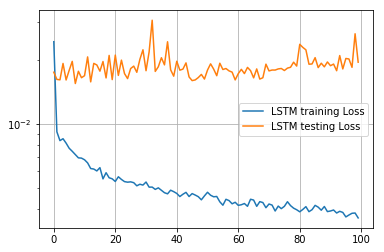

In [34]:
from matplotlib import pyplot
plt.plot(history.history['loss'], label='LSTM training Loss')
plt.plot(history.history['val_loss'], label='LSTM testing Loss')
plt.yscale("log")
plt.grid()
plt.legend()

#### Get predictions

In [35]:
def rolling_lstm_prediction(model,x_test,y_test):
    predictions = list()
    for i in range(len(x_test)):
        # make one-step forecast
        X = x_test[i,:] # select single line
        X = X.reshape(1, 1, len(X))  # reshape for LSTM
        y = y_test[i]
        yhat = lstm_model.predict(X, batch_size=1)[0] # reshape prediction to be just a 1D array
        # store forecast
        predictions.append(yhat[0])
    return predictions

In [36]:
# Generate predictions
yhat = rolling_lstm_prediction(lstm_model,x_test,y_test);
raw_lstm_predictions = pd.DataFrame(yhat,columns = ['lstm_prediction'], index = test_index)

#### Convert data

In [37]:
x_test = pd.DataFrame(x_test, columns = x_columns, index = test_index)
y_test = pd.DataFrame(y_test, columns = ['google_45d'], index = test_index)

In [38]:
# Invert scaling for prediction data
unscaled_lstm_predictions = pd.concat([x_test, raw_lstm_predictions], axis=1)
unscaled_lstm_predictions = pd.DataFrame(scaler.inverse_transform(unscaled_lstm_predictions), columns=unscaled_lstm_predictions.columns, index=unscaled_lstm_predictions.index)

# Invert scaling for actual data
test_data_unscaled = pd.concat([x_test, y_test], axis=1)
test_data_unscaled = pd.DataFrame(scaler.inverse_transform(test_data_unscaled), columns=test_data_unscaled.columns, index=test_data_unscaled.index)

In [39]:
backup['unscaled_lstm_predictions'] = unscaled_lstm_predictions
backup['test_data_unscaled'] = test_data_unscaled

In [40]:
lstm_accuracy=np.sqrt(metrics.mean_squared_error(unscaled_data.google_45d, unscaled_lstm_predictions.lstm_prediction))
print('Accuracy of feedforward model is {} \nAccuracy of LSTM model is {}'.format(round(seq_accuracy,2), round(lstm_accuracy)))

Accuracy of feedforward model is 129.24 
Accuracy of LSTM model is 80.0


/home/matthias/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


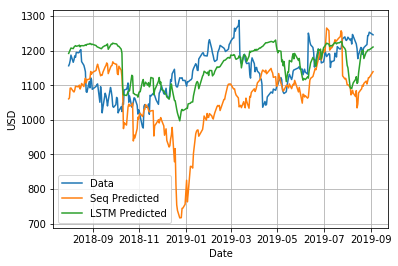

In [3]:
# Plot prediction vs actual
plt.plot(test_data_unscaled['google_45d'], label='Data')
plt.plot(unscaled_seq_predictions['seq_prediction'], label='Seq Predicted')
plt.plot(unscaled_lstm_predictions['lstm_prediction'], label='LSTM Predicted')
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid()
plt.legend()
plt.show()

In [42]:
print('Run time for feedforward model is {} seconds \nRun time for LSTM model is {} seconds'.format(time_seq,time_lstm))

Run time for feedforward model is 411.3968336582184 seconds 
Run time for LSTM model is 167.52475452423096 seconds


In [4]:
backup.close()